In [40]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.neo4j_vector import Neo4jVector
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from getpass import getpass
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate, PromptTemplate
from langchain import hub
from langchain_openai import ChatOpenAI
from graphdatascience import GraphDataScience
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Set up connection information

In [2]:
openai_api_key = getpass()

 ········


In [3]:
neo4j_password = getpass()

 ········


In [4]:
neo4j_uri = "neo4j+s://2fe3bf28.databases.neo4j.io"
neo4j_user = "neo4j"

In [5]:
gds = GraphDataScience(neo4j_uri, auth=(neo4j_user, neo4j_password))

# Set up queries against different vector indexes

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=openai_api_key)

def query_movies(query_string, query_vector, query_type):
    queries = {
        "movie": """CALL db.index.vector.queryNodes("movie_text_vectors", 50, $query_vector) YIELD node, score 
                    RETURN $queryString AS query,
                    "movie" AS index,
                    score, node.tmdbId AS tmdbId, node.title AS title, node.overview AS overview, 
                    node{question: $queryString, .title, .overview} AS map
                    ORDER BY score DESC""",
        "theme": """CALL db.index.vector.queryNodes("theme_vectors", 50, $query_vector) YIELD node, score
                    MATCH (node)<-[:HAS_THEME]-(m)
                    RETURN $queryString AS query,
                    "theme" AS index,
                    collect(node.description) AS theme, 
                    gds.similarity.cosine(m.embedding, $query_vector) AS score, 
                    m.tmdbId AS tmdbId, m.title AS title, m.overview AS overview,
                    m{question: $queryString, .title, .overview} AS map
                    ORDER BY score DESC, gds.similarity.cosine(m.embedding, $query_vector) DESC
                    LIMIT 50
                    """,
        "theme_group": """CALL db.index.vector.queryNodes("theme_group_summary_vectors", 25, $query_vector) YIELD node, score
                          MATCH (node)<-[:IN_GROUP]-()<-[:HAS_THEME]-(m)
                          RETURN $queryString AS query,
                          "theme_group" AS index,
                          collect(node.descriptions) AS theme,
                          gds.similarity.cosine(m.embedding, $query_vector) AS score, 
                          m.tmdbId AS tmdbId, m.title AS title, m.overview AS overview,
                          m{question: $queryString, .title, .overview} AS map
                          ORDER BY score DESC, gds.similarity.cosine(m.embedding, $query_vector) DESC
                          LIMIT 50""",
        "theme_group_mean": """CALL db.index.vector.queryNodes("theme_group_mean_vectors", 25, $query_vector) YIELD node, score
                               MATCH (node)<-[:IN_GROUP]-()<-[:HAS_THEME]-(m)
                               RETURN $queryString AS query,
                               "theme_group_mean" AS index,
                               collect(node.descriptions) AS theme,
                               gds.similarity.cosine(m.embedding, $query_vector) AS score, 
                               m.tmdbId AS tmdbId, m.title AS title, m.overview AS overview,
                               m{question: $queryString, .title, .overview} AS map
                               ORDER BY score DESC, gds.similarity.cosine(m.embedding, $query_vector) DESC
                               LIMIT 50"""
    }
        
    movie_df = gds.run_cypher(queries[query_type], {"queryString": query_string, "query_vector": query_vector, "token":openai_api_key})
    return movie_df

# Ask LLM to determine if the movie returned matches the query

In [7]:
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a movie expert providing information about movies.
                  You will be given a question and information about the title and overview of a movie.
                  Decide whether the movie matches the theme described in the question.
                  If the movie includes the theme, return "yes".
                  If the movie does not incldue the theme, return "no".
                    """),
    ("user", """<question>{question}</question>
    <title>{title}</movie>
    <overview>{overview}</overview>"""),
])
chat = ChatOpenAI(temperature=0, openai_api_key=openai_api_key, model="gpt-3.5-turbo")
chain = prompt | chat

# Run queries against each index and collect results

In [8]:
def compare_retrievers(query):
    query_vector = embeddings.embed_query(query)

    movie_df = query_movies(query, query_vector, "movie")
    theme_df = query_movies(query, query_vector, "theme")
    theme_group_df = query_movies(query, query_vector, "theme_group")
    theme_group_mean_df = query_movies(query, query_vector, "theme_group_mean")
    
    concat_df = pd.concat([movie_df, theme_df.drop("theme", axis=1), 
                           theme_group_df.drop("theme", axis=1), theme_group_mean_df.drop("theme", axis=1)])
    concat_df.drop_duplicates(subset="tmdbId", inplace=True)
    
    concat_df['matches_theme'] = [message.content for message in chain.batch(concat_df['map'].tolist())]
    concat_df.drop(labels=["score", "map", "index"], axis=1, inplace=True)
    concat_df['query'] = query
    
    movie_df = movie_df.merge(concat_df[['tmdbId', 'matches_theme']], how="inner", on="tmdbId")
    theme_df = theme_df.merge(concat_df[['tmdbId', 'matches_theme']], how="inner", on="tmdbId")
    theme_group_df = theme_group_df.merge(concat_df[['tmdbId', 'matches_theme']], how="inner", on="tmdbId")
    theme_group_mean_df = theme_group_mean_df.merge(concat_df[['tmdbId', 'matches_theme']], how="inner", on="tmdbId")
    
    #Shuffle concat_df so you aren't biased when doing the human rakings
    concat_df = concat_df.sample(frac = 1)

    stats_df = pd.DataFrame({
         "query": query,
         "movie_total_records": movie_df['matches_theme'].count(), 
         "movie_matched_records": movie_df['matches_theme'].value_counts()['yes'],
         "movie_percent_matched": movie_df['matches_theme'].value_counts()['yes']/movie_df['matches_theme'].count(),
         "theme_total_records": theme_df['matches_theme'].count(), 
         "theme_matched_records": theme_df['matches_theme'].value_counts()['yes'],
         "theme_percent_matched": theme_df['matches_theme'].value_counts()['yes']/theme_df['matches_theme'].count(),
         "theme_group_total_records": theme_group_df['matches_theme'].count(), 
         "theme_group_matched_records": theme_group_df['matches_theme'].value_counts()['yes'],
         "theme_group_percent_matched": theme_group_df['matches_theme'].value_counts()['yes']/theme_group_df['matches_theme'].count(),
         "theme_group_mean_total_records": theme_group_mean_df['matches_theme'].count(), 
         "theme_group_mean_matched_records": theme_group_mean_df['matches_theme'].count() - theme_group_mean_df['matches_theme'].value_counts()['no'],
         "theme_group_mean_percent_matched": (theme_group_mean_df['matches_theme'].count() - theme_group_mean_df['matches_theme'].value_counts()['no'])/theme_group_mean_df['matches_theme'].count(),
    },
        index=[0])
    
    return movie_df, theme_df, theme_group_df, theme_group_mean_df, stats_df, concat_df

# Gather results for multiple different queries

In [9]:
movie_dfs = []
theme_dfs = []
theme_group_dfs = []
theme_group_mean_dfs = []
stats_dfs = []
concat_dfs = []

queries = ['What are some movies about classical music?', 
           'What are some movies about baseball?', 
           'What are some dark comedies?', 
           'What are some movies about Europe in the 1960s?', 
           'What are some movies about dogs?']

for query in queries:
    movie_df, theme_df, theme_group_df, theme_group_mean_df, stats_df, concat_df = compare_retrievers(query)
    movie_dfs.append(movie_df)
    theme_dfs.append(theme_df)
    theme_group_dfs.append(theme_group_df)
    theme_group_mean_dfs.append(theme_group_mean_df)
    stats_dfs.append(stats_df)
    concat_dfs.append(concat_df)
    print(f"Completed: {query}")

Completed: What are some movies about classical music?


Completed: What are some movies about baseball?


Completed: What are some dark comedies?


Completed: What are some movies about Europe in the 1960s?
Completed: What are some movies about dogs?


In [10]:
final_stats_df = pd.concat(stats_dfs)

# How many records from each index did the LLM think matched the query?

In [11]:
final_stats_df

,query,movie_total_records,movie_matched_records,movie_percent_matched,theme_total_records,theme_matched_records,theme_percent_matched,theme_group_total_records,theme_group_matched_records,theme_group_percent_matched,theme_group_mean_total_records,theme_group_mean_matched_records,theme_group_mean_percent_matched
0,What are some movies about classical music?,50,15,0.30,50,9,0.18,50,17,0.34,50,18,0.36
0,What are some movies about baseball?,50,5,0.10,50,5,0.10,50,6,0.12,50,0,0.00
0,What are some dark comedies?,50,25,0.50,50,34,0.68,50,23,0.46,50,23,0.46
0,What are some movies about Europe in the 1960s?,50,13,0.26,50,4,0.08,50,8,0.16,50,6,0.12
0,What are some movies about dogs?,50,20,0.40,50,17,0.34,50,28,0.56,50,27,0.54


In [69]:
llm_match_summary = final_stats_df[['movie_matched_records', 'theme_matched_records', 'theme_group_matched_records', 'theme_group_mean_matched_records']].sum()

In [73]:
llm_match_summary = llm_match_summary.rename({"movie_matched_records":"movie", 
                                              "theme_matched_records": "theme", 
                                              "theme_group_matched_records": "theme_group",
                                              "theme_group_mean_matched_records": "theme_group_mean"})

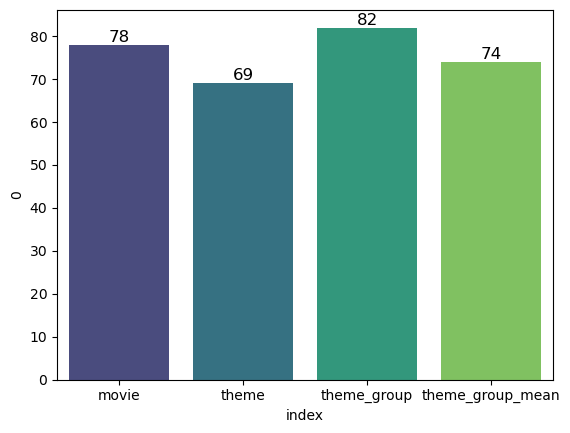

In [74]:
llm_match_summary = llm_match_summary.reset_index()
g = sns.barplot(llm_match_summary, x="index", y=0, hue="index", palette="viridis")
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=12, color='black', ha='center', va='bottom')

In [13]:
final_concat_df = pd.concat(concat_dfs)
final_concat_df.to_csv("movie_classifications.csv", index=False, header=True)
final_movie_df = pd.concat(movie_dfs)
final_theme_df = pd.concat(theme_dfs)
final_theme_group_df = pd.concat(theme_group_dfs)
final_theme_group_mean_df = pd.concat(theme_group_mean_dfs)
final_retrieval_df = pd.concat([final_movie_df, final_theme_df, final_theme_group_df, final_theme_group_mean_df])
final_retrieval_df.to_csv("movie_retrievals.csv", index=False, header=True)

# I reviewed the matches independently to see if I thought the results matched the intent of the query. 
Reread the CSV to get human matches.

In [14]:
human_matched_df = pd.read_csv("movie_classifications.csv")

In [15]:
human_matched_df.head()

,query,tmdbId,title,overview,matches_theme,human_matches_theme,agree
0,What are some movies about classical music?,1141657,Otto Baxter: Not A F***ing Horror Story,"We follow Otto Baxter, a 35-year-old man with ...",N,N,True
1,What are some movies about classical music?,435160,Willie and Me,"Trapped in a stagnant marriage, German housewi...",N,N,True
2,What are some movies about classical music?,1160164,TAYLOR SWIFT | THE ERAS TOUR,The cultural phenomenon continues on the big s...,N,N,True
3,What are some movies about classical music?,1231483,Turn in the Wound,Abel Ferrara explores human conflict and the s...,N,N,True
4,What are some movies about classical music?,1253727,Pioniere der Filmmusik - Europas Sound für Hol...,Hollywood film music has its roots in Europe. ...,Y,Y,True


In [16]:
movie_retrievals_df = final_retrieval_df.merge(human_matched_df[["query", "tmdbId", "human_matches_theme"]], 
                                                on=["query", "tmdbId"], how="inner")

In [17]:
movie_retrievals_df.head()

,query,index,score,tmdbId,title,overview,map,matches_theme,theme,human_matches_theme
0,What are some movies about classical music?,movie,0.726639,1221002,Beautiful Pleasant Trivial,The film is about the possibility of valuing m...,"{'title': 'Beautiful Pleasant Trivial', 'overv...",yes,NaN,Y
1,What are some movies about classical music?,movie,0.725410,1253727,Pioniere der Filmmusik - Europas Sound für Hol...,Hollywood film music has its roots in Europe. ...,{'title': 'Pioniere der Filmmusik - Europas So...,yes,NaN,Y
2,What are some movies about classical music?,movie,0.716922,1233156,I Hear a Symphony,Sometimes music plays at the right time. Somet...,"{'title': 'I Hear a Symphony', 'overview': 'So...",no,NaN,N
3,What are some movies about classical music?,movie,0.701907,1176446,Symphonic Sketches,“Symphonic Sketches” tells the story of one cl...,"{'title': 'Symphonic Sketches', 'overview': '“...",yes,NaN,Y
4,What are some movies about classical music?,movie,0.701348,1193481,Lenechka,Leonid Desyatnikov is the most played Russian ...,"{'title': 'Lenechka', 'overview': 'Leonid Desy...",no,NaN,Y


# Summarize the number of human matched movies per query and index

In [27]:
movie_summary = movie_retrievals_df.groupby(['query', 'index'])['human_matches_theme'].value_counts().reset_index().pivot(columns="human_matches_theme", index=["query", "index"])

In [37]:
movie_summary = pd.DataFrame(movie_summary['count']['Y']).fillna(0).reset_index()

In [42]:
movie_summary

,query,index,Y
0,What are some dark comedies?,movie,20.0
1,What are some dark comedies?,theme,33.0
2,What are some dark comedies?,theme_group,17.0
3,What are some dark comedies?,theme_group_mean,22.0
4,What are some movies about Europe in the 1960s?,movie,10.0
5,What are some movies about Europe in the 1960s?,theme,10.0
6,What are some movies about Europe in the 1960s?,theme_group,14.0
7,What are some movies about Europe in the 1960s?,theme_group_mean,12.0
8,What are some movies about baseball?,movie,14.0
9,What are some movies about baseball?,theme,16.0


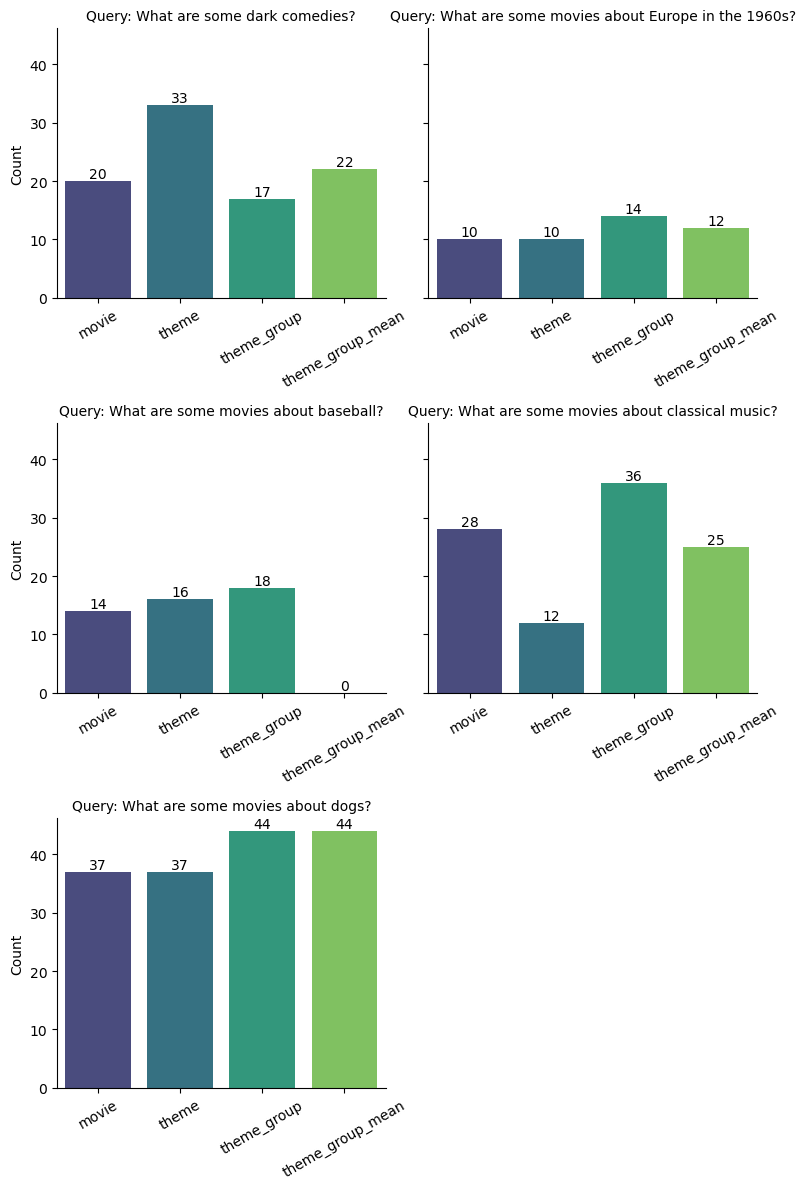

In [51]:
g = sns.FacetGrid(movie_summary, col="query", col_wrap=2, height=4, sharex=False)
g.map_dataframe(sns.barplot, x="index", y="Y", hue="index", palette="viridis")
g.set_axis_labels("", "Count")  # Removed "Index" label

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=30)

# Display count values on each bar
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=10, color='black', ha='center', va='bottom')

# Set titles for each plot
g.set_titles("Query: {col_name}")

plt.tight_layout()
plt.show()

In [61]:
overall_summary

,index,Y
0,movie,109.0
1,theme,108.0
2,theme_group,129.0
3,theme_group_mean,103.0


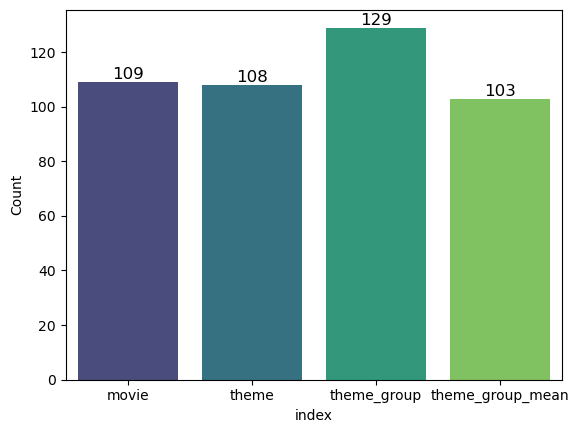

In [77]:
overall_summary = movie_summary.groupby("index")['Y'].sum().reset_index()
g = sns.barplot(overall_summary, x="index", y="Y", hue="index", palette="viridis")
plt.ylabel("Count") 
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=12, color='black', ha='center', va='bottom')


# Examine individual themes that performed well or poorly on specific queries

Theme did a lot better on dark comedy that theme group. Theme picked up on horror-comedy and horror comedy themes that were bundled in with more generic horror topics in the theme groups.

In [21]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'What are some dark comedies?') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['theme', 'theme_group'])][['index','title', 'theme']]

,index,title,theme
350,theme,Silence,[dark comedy]
351,theme,"End All, Say All",[dark comedy]
352,theme,Affirmations,[dark comedy]
353,theme,Dindin,[dark comedy]
354,theme,Accessory,[dark comedy]
355,theme,Død af grin,[dark comedy]
356,theme,Death Perception,[dark comedy]
358,theme,Stand-Up - My Life Is A Joke,[dark comedy]
360,theme,Dead Serious,[romantic comedy]
361,theme,Sweet Dreams,[black comedy]


Theme group mean did very poorly on baseball. What themes was it matching on?

In [22]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'What are some movies about baseball?') 
                    & (movie_retrievals_df['human_matches_theme']=='N')
                    & movie_retrievals_df['index'].isin(['theme_group_mean'])][['index','title', 'theme']]

,index,title,theme
800,theme_group_mean,Why Movies?,"[[film adaptation, film success, filmography, ..."
801,theme_group_mean,The Movie Man,"[[Movie man, Rocket movies, action movies, mov..."
802,theme_group_mean,The Hurler: A Campion's Tale,"[[Sports drama, Sports scandal]]"
803,theme_group_mean,A Love Letter to Cinema,"[[Cinema Comfama, Cinema Odyssey, Cinema closu..."
804,theme_group_mean,Rendezvous,"[[movie marathon, movie museum, movie theater]]"
805,theme_group_mean,From 8 Movies To 1,"[[Film History, Film collector, film education..."
806,theme_group_mean,Mountainside,"[[Movie man, Rocket movies, action movies, mov..."
807,theme_group_mean,Monti the Movie 3: The F#%kening,"[[film adaptation, film success, filmography, ..."
808,theme_group_mean,Trouble with Johnny,"[[Movie man, Rocket movies, action movies, mov..."
809,theme_group_mean,Brothers,"[[Sports injury, Sports-entertainment, life af..."


In [24]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'What are some movies about baseball?') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['theme_group'])][['index','title', 'theme']]

,index,title,theme
550,theme_group,Thunder Rolls! The World of Blind Baseball,"[[Baseball academy, Blind baseball, College Na..."
551,theme_group,Young Again,"[[Baseball academy, Blind baseball, College Na..."
552,theme_group,Shohei Ohtani: Beyond the Dream,[[MLB stardom]]
553,theme_group,Monster Under The River,"[[Baseball academy, Blind baseball, College Na..."
554,theme_group,Indoor Baseball,"[[Baseball academy, Blind baseball, College Na..."
555,theme_group,The Astros Edge,"[[Baseball academy, Blind baseball, College Na..."
556,theme_group,unDEFILED,"[[Baseball academy, Blind baseball, College Na..."
557,theme_group,Carson Bigbee: The Pirate of America's Pastime,"[[Baseball academy, Blind baseball, College Na..."
558,theme_group,Kanashimi,"[[Baseball academy, Blind baseball, College Na..."
559,theme_group,Samurai Japan: The Story Behind the WBC Clean ...,"[[Baseball academy, Blind baseball, College Na..."


Theme group did a lot better on theme for classical music. What themes did theme group pick up that theme missed?

In [25]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'What are some movies about classical music?') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['theme', 'theme_group'])][['index','title', 'theme']]

,index,title,theme
250,theme,Beautiful Pleasant Trivial,"[musical works, classical]"
251,theme,Pioniere der Filmmusik - Europas Sound für Hol...,[Film music]
252,theme,Symphonic Sketches,[classical music]
253,theme,Music Genres. Voices of the World,[classics]
254,theme,Asfalto che suona,[anti-classical]
256,theme,Sergey Slonimsky. Bells,[musical]
257,theme,Crescendo,[classical music]
261,theme,Symphony n. 9 by Ludwig van Beethoven in St. M...,[classical music]
264,theme,"Marta, la musical. Una ópera de Dani Umpi.",[musical]
267,theme,Als ik zelf de zon ben,[classical music]


Theme group did really well at dogs. What themes did it use?

In [26]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'What are some movies about dogs?') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['theme_group'])][['index','title', 'theme']]

,index,title,theme
700,theme_group,Dogman,"[[Beautiful dogs, Companion AI, Companion dog,..."
701,theme_group,Dog Days,"[[Beautiful dogs, Companion AI, Companion dog,..."
702,theme_group,We Are All Dogs,"[[Beautiful dogs, Companion AI, Companion dog,..."
703,theme_group,Little Death,"[[Beautiful dogs, Companion AI, Companion dog,..."
704,theme_group,Life's a Bitch,[[Chihuahua]]
705,theme_group,Wet Dogs,[[Wet dogs]]
706,theme_group,Dogs at the Opera,"[[Beautiful dogs, Companion AI, Companion dog,..."
707,theme_group,Love Death Dog,"[[Beautiful dogs, Companion AI, Companion dog,..."
708,theme_group,Thank You for Your Service,"[[Beautiful dogs, Companion AI, Companion dog,..."
709,theme_group,A Dog Called Laura,"[[Beautiful dogs, Companion AI, Companion dog,..."
